# Digit Classification Model

Building a digit classification model using CNN resnet architecture

# Author

**Amal Varghese**

- [Linkedin](https://www.linkedin.com/in/amal-varghese-670225291/)
- [Github](https://github.com/codewizard-2004)

#Importing necessary libraries


In [1]:
import torch
import torchvision
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm
import numpy as np

print(torch.__version__)
print(torchvision.__version__)

2.4.1+cu121
0.19.1+cu121


In [2]:
try:
  import torchmetrics, mlxtend
  assert int(mlxtend.__version__.split(".")[1]) >=19, "mlxtend should be 0.19 or higher"
  print("torchmetrics and mlxtend are already installed")
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  print(f"torchmetrics version: {torchmetrics.__version__}")

torchmetrics and mlxtend are already installed


#loading the dataset from PyTorch Datasets

In [3]:
train_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

#Exploaratoray data analysis

In [4]:
print(f"Total size: {len(train_data) + len(test_data)}")
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

Total size: 70000
Train size: 60000
Test size: 10000


In [5]:
#sample data
image , digit = train_data[0]
class_names = train_data.classes
print(f"image shape:{image.shape}")
print(f"digit:{digit}")

image shape:torch.Size([1, 28, 28])
digit:5


In [6]:
torch.manual_seed(42)

def visualize_image_batch(image_data: torch.tensor,class_names:list, row=1 , cols=1, cmap = "gray"):
  """
  Visualize a batch of data from a data loader with specified number of rows and columns
  by default row = 1  col = 1
  """
  fig = plt.figure(figsize = (9,9))
  for i in range(1 , row*cols+1):
    random_idx = torch.randint(0, len(image_data) , size = [1]).item()
    img , label = image_data[random_idx]
    fig.add_subplot(row, cols, i)
    plt.imshow(img.squeeze(), cmap = cmap)
    plt.title(class_names[label])
    plt.axis(False)

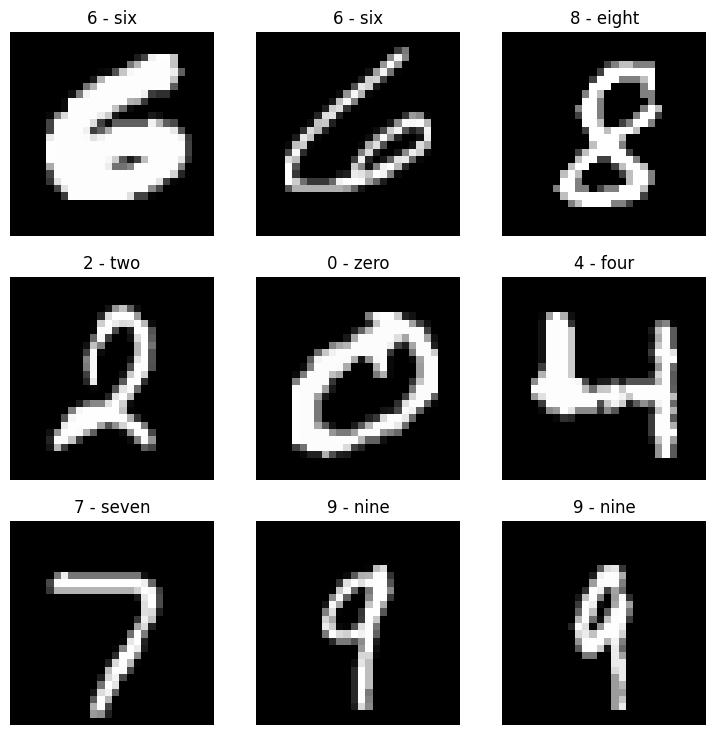

In [7]:
visualize_image_batch(row = 3 , cols = 3 ,image_data = train_data, class_names = class_names)

Now lets convert our data into a python iterable using DataLoader


In [8]:
#Set a Batch Size for memory efficiency

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

print(f"Train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Train dataloader: 1875 batches of 32
Test dataloader: 313 batches of 32


In [9]:
train_features_batch , train_labels_batch = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features_batch.size()}")
print(f"Labels batch shape: {train_labels_batch.size()}")

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


# Creatgin oru model using CNN resent PyTorch

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
class HandwrittenDigitClassifier(nn.Module):
  def __init__(self , input_shape: int , hidden_units: int , output_shape: int):
    super().__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape , out_channels=hidden_units, kernel_size = 3, stride=1 , padding=0),
        nn.ReLU()
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units , out_channels=hidden_units , kernel_size=1 , stride=1 , padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2 , stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units*13*13 , out_features=output_shape)
    )

  def forward(self , X: torch.tensor):
    X = self.block_1(X)
    X = self.block_2(X)
    X = self.classifier(X)
    return X

using a dummy image to find the output shape

In [12]:
image_dummy = torch.randn(size=(32, 1, 28, 28))
print(f"image shape batch: {image_dummy.shape}")
print(f"dummy single image:{image_dummy[0].shape}")

image shape batch: torch.Size([32, 1, 28, 28])
dummy single image:torch.Size([1, 28, 28])


In [13]:
block_1 = nn.Sequential(
        nn.Conv2d(in_channels=1 , out_channels= 10, kernel_size = 3, stride=1 , padding=0),
        nn.ReLU()
    )
block_2 = nn.Sequential(
        nn.Conv2d(in_channels=10 , out_channels= len(class_names) , kernel_size=1 , stride=1 , padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2 , stride=2)
    )

X = block_1(image_dummy)
print(f"block 1 output shape: {X.shape}")
X = block_2(X)
print(f"block 2 output shape: {X.shape}")

block 1 output shape: torch.Size([32, 10, 26, 26])
block 2 output shape: torch.Size([32, 10, 13, 13])


**Creating an object of the model**


In [14]:
torch.manual_seed(42)

model_0 = HandwrittenDigitClassifier(
    input_shape = 1,
    hidden_units = 10,
    output_shape = len(class_names)
).to(device)

model_benchmark = HandwrittenDigitClassifier(
    input_shape = 1,
    hidden_units = 10,
    output_shape = len(class_names)
).to(device)

In [15]:
model_0.state_dict()

OrderedDict([('block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
           

We have created a model with TinyVGG architecture, lets do some sample testing with this untrained model

# Setup loss function and optimizer

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters() , lr = 0.1)

In [17]:
def get_train_time(start: float,
                   end: float,
                   device: torch.device = device):
  """
  gives the time taken between start and end time of a model
  """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [18]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device=device):
  '''
  Returns a dictionary containing the results of the model predicting on data_loader
  '''
  loss, acc = 0 , 0
  model.eval()
  model.to(device)
  with torch.inference_mode():
    #device agnostic
    for X,y in tqdm(data_loader):
      X,y = X.to(device) , y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred , y)
      acc += accuracy_fn(y_true = y , y_pred = y_pred.argmax(dim=1))

    #scale the loss and acc to find the avg loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__ ,
          "model_loss":loss.item() ,
          "model_acc":acc}


In [19]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc


In [20]:
#Training loop


def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """
    Performs training with model trying to learn on data loader
  """
  train_loss , train_acc = 0 , 0
  test_loss_stack = []
  train_loss_stack = []
  model.train()

  for batch, (X,y) in enumerate(data_loader):

    X,y = X.to(device) , y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred , y)
    train_loss_stack.append(loss)
    train_loss += loss
    train_acc += accuracy_fn(y_true = y , y_pred = y_pred.argmax(dim=1))#Logits -> prediction labels

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%\n")
  return train_loss_stack


In [21]:
#Creating a testing loop

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """
  Perform a testing loop step on model going over data loader
  """
  test_loss , test_acc = 0 , 0
  test_loss_stack = []

  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device) , y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred , y)
      test_loss_stack.append(loss)
      test_loss += loss
      test_acc += accuracy_fn(y_true = y , y_pred = test_pred.argmax(dim=1))

    #Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")
    return test_loss_stack

In [22]:
def make_single_prediction(model: torch.nn.Module,
                           img: torch.tensor,
                           class_names: list,
                           display: bool= True):
  """
  Makes a single prediction on a single image
  """
  pred_logits = model(img.to(device).unsqueeze(dim = 0)).to(device)
  pred_probs = pred_logits.argmax(dim = 1)
  if display:
    print(f"Predicted Output: {class_names[pred_probs]}")
  return pred_probs

In [23]:
make_single_prediction(model_0 , image , class_names)

Predicted Output: 3 - three


tensor([3])

In [24]:
image.shape

torch.Size([1, 28, 28])

In [25]:
import random
def make_random_predictions(model: nn.Module,
                            count: int,
                            test_data: torchvision.datasets,
                            rows:int ,
                            cols: int,
                            class_names: list,
                            seed:int = 42):
  '''
    This function will give random predctions of amount of count given by the user

    Args:
      model: the model to make prediction
      count: the number of predictions
      test_data: The data on which predictions are made use torchvision.datasets
      class_names: A lsit containing all the labels
      seed: random seeding , 42 by default
  '''
  torch.manual_seed(seed)
  random_numbers = [random.randint(0, len(test_data) - 1) for _ in range(count)]
  plt.figure(figsize=(20,20))

  for idx, i in enumerate(random_numbers):
      sample, label = test_data[i]

      # Plot the sample
      plt.subplot(rows, cols, idx + 1)  # idx + 1 for correct subplot positioning
      plt.imshow(sample.squeeze(), cmap="gray")
      plt.axis('off')  # Hide axes

      # Make prediction
      pred = make_single_prediction(model_0, sample , class_names, False)

      # Title with color coding (green for correct, red for incorrect)
      if pred == label:
          plt.title(f"Predicted:{class_names[pred]}|Actual:{class_names[label]}",  color="g")
      else:
          plt.title(f"Predicted:{class_names[pred]}|Actual:{class_names[label]}", color="r")

  # Adjust the layout to prevent overlap
  plt.show()

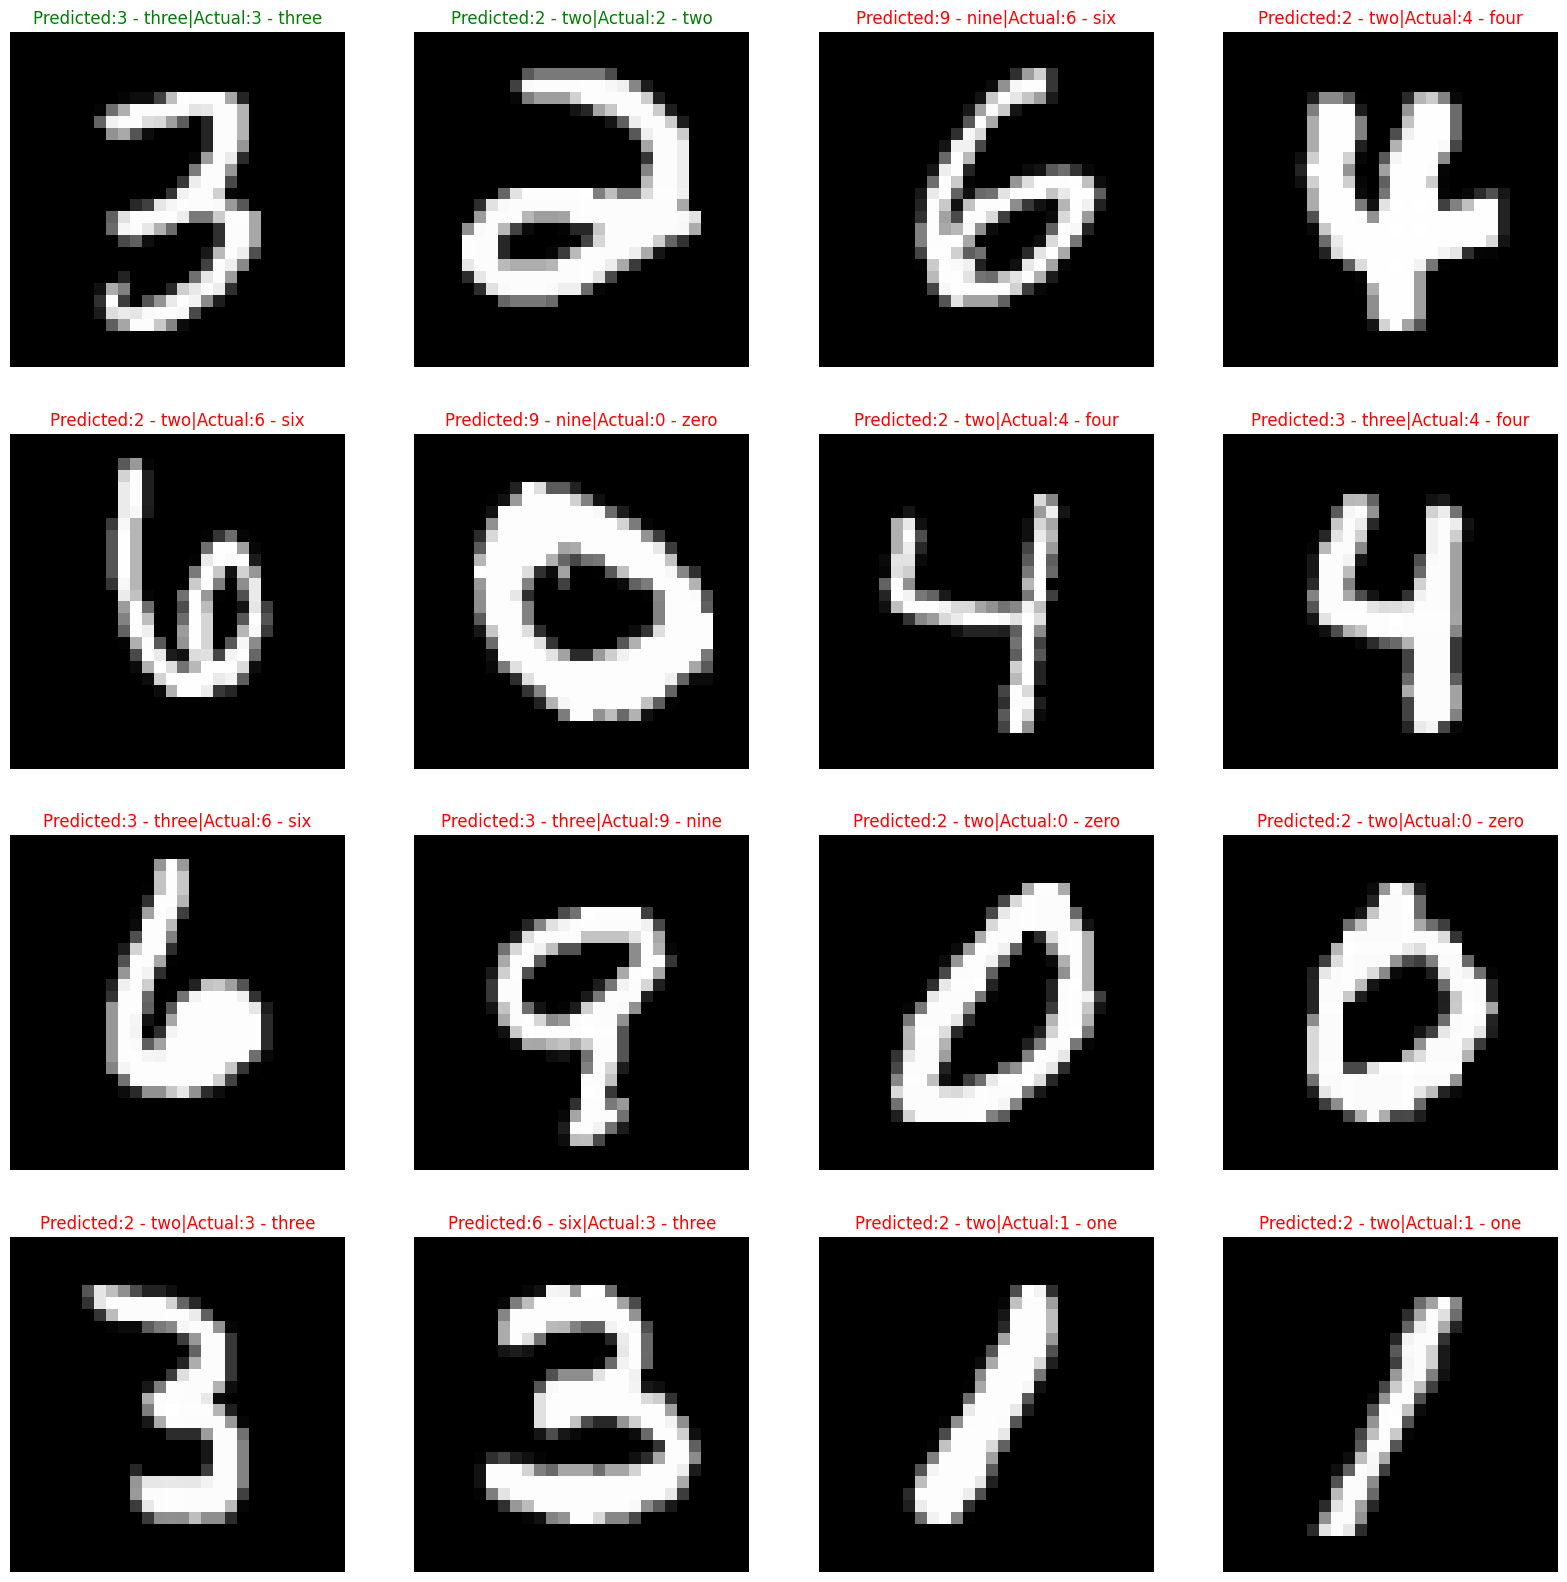

In [26]:
make_random_predictions(model_0 , 16 , rows=4 , cols=4 ,test_data= test_data ,class_names= class_names)

As we can see our model makes terrible predictions

In [27]:
#train the model
torch.manual_seed(42)

train_time_start = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch:{epoch}\n----------")
  train_loss_list = train_step(model = model_0,
             data_loader = train_dataloader,
             optimizer=optimizer,
             loss_fn = loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)
  test_loss_list = test_step(model = model_0,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end = timer()
total_train_time = get_train_time(start = train_time_start,
                                  end = train_time_end)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:0
----------
Train loss: 0.33265 | Train acc: 89.96%

Test loss: 0.15591 | Test acc: 95.21%

Epoch:1
----------
Train loss: 0.12839 | Train acc: 96.21%

Test loss: 0.08482 | Test acc: 97.48%

Epoch:2
----------
Train loss: 0.08836 | Train acc: 97.34%

Test loss: 0.07573 | Test acc: 97.59%

Train time on cpu: 114.943 seconds


# Evaluating our model

In [28]:
train_results = eval_model(model=model_0,
                           data_loader=train_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn,
                           device=device)

  0%|          | 0/1875 [00:00<?, ?it/s]

In [29]:
train_results

{'model_name': 'HandwrittenDigitClassifier',
 'model_loss': 0.07299704104661942,
 'model_acc': 97.76333333333334}

As we can see our model now has an accuracy of 97% which means our model has learnt the patterns of the data

**Confusion matrix of the model**

In [30]:
y_preds = []
model_0.eval()

with torch.inference_mode():
  for X,y in tqdm(test_dataloader , desc="Collecting predicitons"):
    X,y = X.to(device) , y.to(device)
    y_logits = model_0(X)
    y_pred = torch.softmax(y_logits , dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_preds = torch.cat(y_preds)
print(y_preds)

tensor([7, 2, 1,  ..., 4, 5, 6])


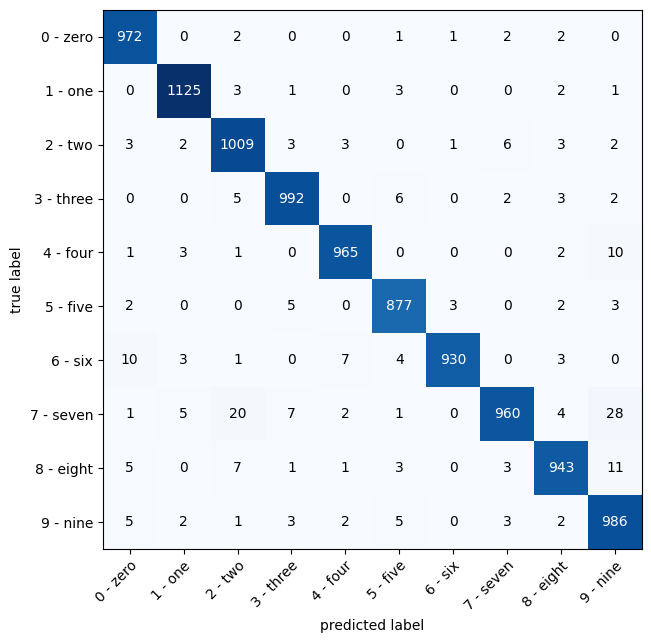

In [31]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names) , task="multiclass")
confmat_tensor = confmat(preds = y_preds ,
                         target = test_data.targets)
#plot the confusion matrix
fig , ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    figsize=(10,7),
    class_names=class_names
)

# lets make some predictions

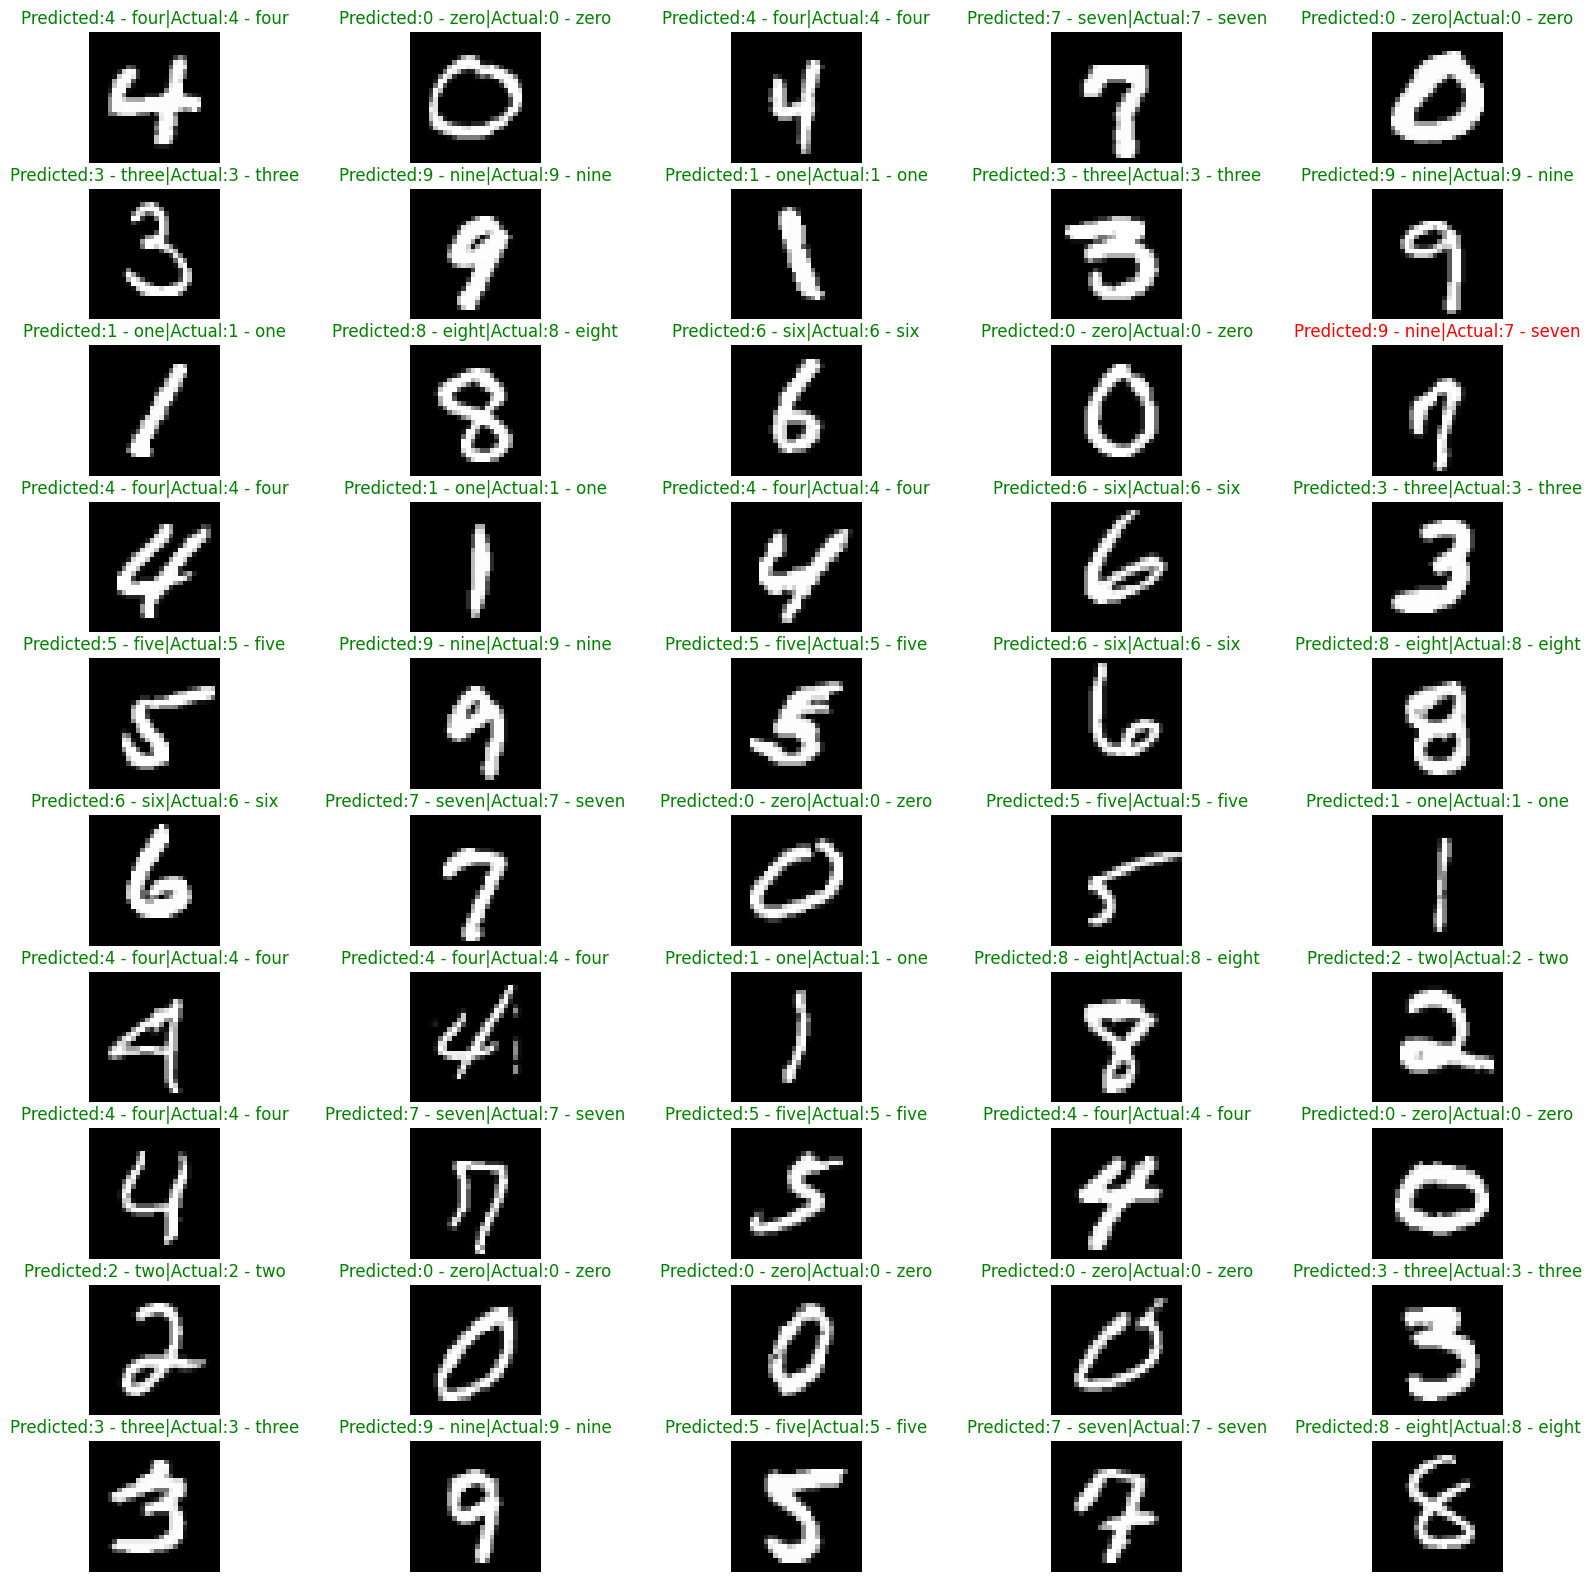

In [32]:
make_random_predictions(model_0 ,
                        count=50,
                        rows=10 ,
                        cols =5 ,
                        test_data=test_data,
                        class_names=class_names)

As we can see our model is doing well in these predictions

# Saving the model

In [33]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True , exist_ok=True)

#create model save
model_name = "HandwrittenModel.pth"
model_save_path = model_path / model_name

#save model sate dict
torch.save(obj=model_0.state_dict() , f=model_save_path)
#

In [34]:
try:
  import gradio_client,gradio
  print("Libraries already installed")
except:
  !pip install gradio
  !pip install gradio_client
  print(gradio.__version__)

Libraries already installed


#Loading a saved Model

In [35]:
loaded_model = HandwrittenDigitClassifier(
    input_shape = 1,
    hidden_units = 10,
    output_shape = len(class_names)
).to(device)

loaded_model.load_state_dict(torch.load(f=model_save_path))

<ipython-input-35-611a456baa16>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=model_save_path))


<All keys matched successfully>

In [36]:
import gradio as gr
from PIL import Image
import torch
from torchvision import transforms

# Function to resize, convert the image to grayscale, and then to a PyTorch tensor
def process_image(image):
    if image is None:
        return "No image uploaded. Please upload an image."

    try:
        # Resize the image to 28x28
        resized_image = image.resize((28, 28))

        # Convert the image to grayscale (1 color channel)
        grayscale_image = resized_image.convert('L')

        # Convert the grayscale image to a PyTorch tensor
        to_tensor = transforms.ToTensor()  # Converts a PIL Image to tensor
        image_tensor = to_tensor(grayscale_image)

        preds = make_single_prediction(model_0 , image_tensor , class_names).item()



        # Return a success message including tensor shape
        return f"The number is {preds}."
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Create the Gradio interface
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            # File upload component
            image_input = gr.Image(type="pil", label="Upload Image")

            # Submit button
            submit_button = gr.Button("Submit")

        with gr.Column():
            # Output text
            output_text = gr.Textbox(label="Message", placeholder="Your message will appear here.")

    # Link the button to trigger the function and display the output message
    submit_button.click(fn=process_image, inputs=image_input, outputs=output_text)

# Launch the Gradio app
demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f58bd57c40c3572c7f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Try our model with MNIST Images

Here are some sample MNIST images:

<table>
  <tr>
    <td><img src="https://raw.githubusercontent.com/codewizard-2004/MNISTdigitModel/refs/heads/main/Sampledata/0/0.jpg" width="50"/></td>
    <td><img src="https://raw.githubusercontent.com/codewizard-2004/MNISTdigitModel/refs/heads/main/Sampledata/1/1.jpg" width="50"/></td>
    <td><img src="https://raw.githubusercontent.com/codewizard-2004/MNISTdigitModel/refs/heads/main/Sampledata/2/2.jpg" width="50"/></td>
    <td><img src="https://raw.githubusercontent.com/codewizard-2004/MNISTdigitModel/refs/heads/main/Sampledata/3/3_2.jpg" width="50"/></td>
    <td><img src="https://raw.githubusercontent.com/codewizard-2004/MNISTdigitModel/refs/heads/main/Sampledata/4/4_3.jpg" width="50"/></td>
    <td><img src="https://raw.githubusercontent.com/codewizard-2004/MNISTdigitModel/refs/heads/main/Sampledata/5/5.jpg" width="50"/></td>
    <td><img src="https://raw.githubusercontent.com/codewizard-2004/MNISTdigitModel/refs/heads/main/Sampledata/6/6_2.jpg" width="50"/></td>
    <td><img src="https://raw.githubusercontent.com/codewizard-2004/MNISTdigitModel/refs/heads/main/Sampledata/7/7_3.jpg" width="50"/></td>
    <td><img src="https://raw.githubusercontent.com/codewizard-2004/MNISTdigitModel/refs/heads/main/Sampledata/8/8.jpg" width="50"/></td>
    <td><img src="https://raw.githubusercontent.com/codewizard-2004/MNISTdigitModel/refs/heads/main/Sampledata/9/9.jpg" width="50"/></td>
  </tr>
</table>


I have uploaded 3 images of each digit in my GitHub Repository [here](https://github.com/codewizard-2004/MNISTdigitModel/tree/main/Sampledata)

To download more go to [official](https://yann.lecun.com/exdb/mnist/) website
